# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from skimage import morphology
import matplotlib.image as mpimg
import random
from sklearn.cluster import KMeans
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os
from PIL import ImageColor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from skimage import transform

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from skimage import morphology
import matplotlib.image as mpimg
import random
from sklearn.cluster import KMeans
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
import os
from PIL import ImageColor
import seaborn as sns

# Loading data

In [2]:
features = pd.read_csv(r'../features/features.csv')
ground_truth = pd.read_csv(r"../data/example_ground_truth.csv")


# Functions

In [3]:
def calculate_area(image):
    """
    image = a numpy array
    """
    return np.sum(image)

def calculate_border(image,thickness):
    """
    image = np array of a picture
    thicness = an integer of the thiccness of the border
    returns = the border of the figure
    """
    struct_el = morphology.disk(thickness)
    mask_eroded = morphology.binary_erosion(image, struct_el)
    return calculate_area(image)-np.sum(mask_eroded)


def compactness(area, border):
    """
    area = the area of the figure
    border = the circumference of the figure
    return = returns the compactness
    """
    top = border**2
    bot = 4*math.pi*area
    return top/bot

def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))



def average_colour(image,segmentation):
    mask = segmentation == 1
    copy = image.copy()
    r = np.mean(copy[mask,0])
    g = np.mean(copy[mask,1])
    b = np.mean(copy[mask,2])
    #num_of_pixels = copy[mask].shape[0]
    return [r,g,b]

def deviation_of_colour(image,segmentation):
    mask = segmentation == 1
    copy = image.copy()
    r = np.std(copy[mask,0])
    g = np.std(copy[mask,1])
    b = np.std(copy[mask,2])
    return [r,g,b]

def average_luminosity(image,segmentation):
    avg_colour = average_colour(image,segmentation)
    return 0.299*avg_colour[0] + 0.587*avg_colour[1] + 0.114*avg_colour[2]

def deviation_luminosity(image,segmentation):
    deviation_colour = deviation_of_colour(image,segmentation)
    return np.sqrt(0.299**2*deviation_colour[0]**2 + 0.587**2*deviation_colour[1]**2 + 0.114**2*deviation_colour[2]**2)

def findImage(image_id):
    image = plt.imread('../data/example_image/'+image_id+'.jpg')
    image_seg = plt.imread('../data/example_segmentation/'+image_id+'_segmentation.png')
    return image,image_seg

def make_knn_prediction(k):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(x_train, y_train)
    return neigh.predict(x_test)

def from_rgb_to_int(df):
    placeholder = [RGB2HEX(elm) for elm in df]
    hex_val = [int("0x" + elm[1:],0) for elm in placeholder]
    return hex_val

def knn_model_constructor(k,training,labels):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(training, labels)
    return model

def crop_segmentation(img,tol=0):
    # img is 2D image data
    # tol  is tolerance
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

#Gino is the boss
def centerpoint(mask):
    borders = np.where(mask != 0) # This will return 2 arrays with the index where the pixels are ones
    up, down, left, right = max(borders[0]), min(borders[0]), min(borders[1]), max(borders[1])
    center = ((up+down) //2, (left + right) //2) # Tuple with the coordinates for the center of the lesion
    return center

In [4]:
def assymetry(segmentation):
    left_symmetric_differences = []
    right_symmetric_differences =[]
    for angle in range(0,46,10):
        cropped = crop_segmentation(transform.rotate(segmentation, angle))
        
        
        #cropped = crop_segmentation(segmentation)
        center = centerpoint(cropped)
        center = (center[1],center[0])

        #LEFT part
        left_horizontal_segmentation = cropped[:,0:center[0]+1].astype(float)
        left_flipped_segmentation = np.fliplr(cropped)[:,0:center[0]+1].astype(float)

        overlap_left_segmentation = cv2.addWeighted(left_horizontal_segmentation, 0.5, left_flipped_segmentation, 0.5, 1.0)

        #Right part
        right_horizontal_segmentation = cropped[:,center[0]:].astype(float)
        right_flipped_segmentation = np.fliplr(cropped)[:,center[0]:].astype(float)

        overlapping_right_horizontal_segmentation = cv2.addWeighted(right_horizontal_segmentation, 0.5, right_flipped_segmentation, 0.5, 1.0)

        def right_horizontal_symmetry(right_horizontal_image, left_flipped_image):
            img_bwa = cv2.bitwise_and(right_horizontal_image,left_flipped_image)
            img_bwo = cv2.bitwise_or(right_horizontal_image,left_flipped_image)
            img_bwx = cv2.bitwise_xor(right_horizontal_image,left_flipped_image)
            symmetry_right = np.count_nonzero(img_bwa)
            total_size_right = np.count_nonzero(img_bwo)
            asymmetry_right = np.count_nonzero(img_bwx)
            return asymmetry_right

        def left_horizontal_symmetry(left_horizontal_image, right_flipped_image):
            img_bwa = cv2.bitwise_and(left_horizontal_image,right_flipped_image)
            img_bwo = cv2.bitwise_or(left_horizontal_image,right_flipped_image)
            img_bwx = cv2.bitwise_xor(left_horizontal_image,right_flipped_image)
            symmetry_left = np.count_nonzero(img_bwa)
            total_size_left = np.count_nonzero(img_bwo)
            asymmetry_left = np.count_nonzero(img_bwx)
            return asymmetry_left

        x = right_horizontal_symmetry(right_horizontal_segmentation,right_flipped_segmentation)
        y = left_horizontal_symmetry(left_horizontal_segmentation,left_flipped_segmentation)
        
        right_diff_percentage = x / calculate_area(right_horizontal_segmentation)
        left_diff_percentage = y / calculate_area(left_horizontal_segmentation)
        
        left_symmetric_differences.append(left_diff_percentage)
        right_symmetric_differences.append(right_diff_percentage)
        
        
    #return x,y,left_horizontal_segmentation,right_horizontal_segmentation
    return round(np.mean([min(left_symmetric_differences),min(right_symmetric_differences)]),3)
    
    

# Task 0: Exploring the data

In [ ]:
#rename column 'id' to 'image_id'
features.rename(columns={'id': 'image_id'}, inplace=True)

In [ ]:
# Here we merge the two data frames
all_feature_merge = features.merge(ground_truth, on='image_id', how='right')

In [ ]:
# Here we plot the dataframe
all_feature_merge

In [ ]:
# Here we check for missing values, which we do not have
all_feature_merge.isna().any()

# Task 1: implement two features

In [ ]:
# Here we are creating masks for which we are going to sort our data

In [ ]:
mask = ground_truth['melanoma'] == 1
melanoma_mask = ground_truth[mask]

In [ ]:
mask = ground_truth['seborrheic_keratosis'] == 1
keratosis_mask = ground_truth[mask]

In [ ]:
# Here we create a couple lists with the data
# the structure of the lists are [("Image_id", "np_array of the picture", "np_array of the mask")]

In [ ]:
# total_data = []
# melanoma_data = []
# keratosis_data = []
# non_infected_data = []
# x = 0

# for image_id in ground_truth['image_id']:
#     print(image_id,x)
#     image = plt.imread('../data/example_image/'+image_id+'.jpg') # Here we load the image
#     image_seg = plt.imread('../data/example_segmentation/'+image_id+'_segmentation.png') # Here we load the mask
#     if image_id in list(melanoma_mask['image_id']): # If the image id is in the melanoma list, label it as melanoma
#         melanoma_data.append((image_id,image,image_seg)) #else label it as keratosis
#     if image_id in list(keratosis_mask['image_id']):
#         keratosis_data.append((image_id,image,image_seg))
#     if (image_id not in list(keratosis_mask['image_id'])) and (image_id not in list(melanoma_mask['image_id'])): # If the image id is in the melanoma list, label it as melanoma
#         non_infected_data.append((image_id,image,image_seg))
#     total_data.append((image_id,image,image_seg)) #Here we have a list of all the data together
#     x += 1

In [ ]:
# Here we get the id of the first legion
melanoma_data[0][0]

In [ ]:
# Here we create the mask
id_mask = all_feature_merge['image_id'] == 'ISIC_0012099'

In [ ]:
area = calculate_area(melanoma_data[0][2])

In [ ]:
print("Here is the actual area {} and here is the computed area".format(int(all_feature_merge[id_mask]['area'])), area)

In [ ]:
# This shows us that our function is correct. This is important because we are using the 
# calculate_area function in the perimeter Function

In [ ]:
# Now we compare our border function

In [ ]:
border = calculate_border(melanoma_data[0][2],1)

In [ ]:
print("Here is the actual area {} and here is the computed area".format(int(all_feature_merge[id_mask]['perimeter'])), border)

In [ ]:
# Now we are going to compute the compactness

In [ ]:
print("Legion: {} Compactness: {}".format(melanoma_data[0][0],compactness(area,border)))

# Task 02

In [ ]:
label = []
for elm in zip(all_feature_merge['melanoma'],all_feature_merge['seborrheic_keratosis']):
    
    if elm[0] == 1.0:
        #print("hej")
        label.append(1.0)
    if elm[1] == 1.0:
        label.append(2.0)
    if (elm[0] == 0.0) and (elm[1] == 0.0):
        label.append(0)
    #print(type(elm[0]))
#len(label)
all_feature_merge['label'] = label

In [ ]:
#Export features from images
# data = pd.DataFrame()
# count = 0
# rows = []
# for image_id in all_feature_merge['image_id']:
#     print(image_id,count)
    
#     image = plt.imread('../data/example_image/'+image_id+'.jpg')
#     image_seg = plt.imread('../data/example_segmentation/'+image_id+'_segmentation.png')
#     #data['image_id'] = image_id
#     real_area = int(all_feature_merge[all_feature_merge['image_id'] == image_id]['area'])
#     real_perimeter = int(all_feature_merge[all_feature_merge['image_id'] == image_id]['perimeter'])
#     thing = all_feature_merge['image_id'] == image_id
#     label = int(all_feature_merge[thing]['label'])

#     calculated_area = int(calculate_area(image_seg))
#     calculated_perimeter = calculate_border(image_seg,1)
#     #print(real_perimeter, calculated_perimeter)
#     imgCompactness = compactness(calculate_area(image_seg),calculate_border(image_seg,1))
#     average_rgb = average_colour(image,image_seg)
#     deviation_of_rgb = deviation_of_colour(image,image_seg)
#     average_luminosity_img = average_luminosity(image,image_seg)
#     deviation_luminosity_img = deviation_luminosity(image,image_seg)
#     row = [label,image_id, real_area, real_perimeter,calculated_area,calculated_perimeter,imgCompactness,average_rgb,deviation_of_rgb,average_luminosity_img,deviation_luminosity_img]
#     rows.append(row)
#     count+= 1

# data = pd.DataFrame(rows, columns = ['label','image_id','real_area','real_perimeter','calculated_area','calculated_perimeter','compactness','average_rgb','deviation_of_colour','average_luminosity','deviation_luminosity'])

In [ ]:
data = pd.read_csv('../data/final_df.csv')
data = data.drop(columns='Unnamed: 0')

In [ ]:
# Here we create a backup of the data, since the creating of the dataframe is really time consuming
backup = data.copy()

# Testing and cross validation

### Test 01 without the color

In [ ]:
data = data.drop(columns = ['calculated_area', 'calculated_perimeter'])
data = data.drop(columns = ['average_rgb','deviation_of_colour'])

In [ ]:
# Here we get all the data from the dataframe, excluding the id and label
np_data = np.array(data.iloc[:,2:11])

In [ ]:
# Here we get the labels
label = np.array(data.iloc[:,0:1])

In [ ]:
# Here we convert the labels to integers
label = [int(x) for x in label]

In [ ]:
# Here we use sk-learns split function to create our training and test data
x_train, x_test, y_train, y_test = train_test_split(np_data,label,test_size=0.2, random_state = 4)

In [ ]:
# x_train is the training data
# y_train is the training labels
# x_test is the testing data
# y_test is the testing labels

In [ ]:
# Here we make a accuacy score for different k's
acc = []
for i in range(1,len(x_train)//3):
    pred = make_knn_prediction(i) #Here i create the prediction and appending it
    acc.append((accuracy_score(y_test, pred)))

In [ ]:
#Here we create a plot of the sores vs the value of k
plt.plot
plt.ylabel('Prediction accuracy')
plt.xlabel('Value of K')
plt.title('Prediction by our KNN-model for different values of k')
plt.ylim(0.2,0.8)
plt.plot(acc)
plt.grid()
plt.show()

In [ ]:
# Here we define our model
knn = knn_model_constructor(11,np_data, label)

In [ ]:
# Here we use cross validation to give it a more accurate representation of its accuracy
scores = cross_val_score(knn, np_data, label, cv=5)

In [ ]:
scores

In [ ]:
# Here we print the average score from the cross validation
sum(scores)/5

### Test 02 same test but we use the log on the data

In [ ]:
data = backup.copy()

In [ ]:
data = backup.copy()
data = data.drop(columns = ['calculated_area', 'calculated_perimeter'])
data = data.drop(columns = ['average_rgb','deviation_of_colour'])

In [ ]:
#Since compactness are such low values, there is no need to take the log of it
for elm in data.iloc[:,2:]:
    if max(data[elm]) > max(data['compactness']):
        data[elm] = np.log10(data[elm])

In [ ]:
# Here we get all the data from the dataframe, excluding the id and label
np_data = np.array(data.iloc[:,2:11])
# Here we get the labels
label = np.array(data.iloc[:,0:1])
# Here we convert the labels to integers
label = [int(x) for x in label]
# Here we use sk-learns split function to create our training and test data
x_train, x_test, y_train, y_test = train_test_split(np_data,label,test_size=0.2, random_state = 4)
# Here we make a accuacy score for different k's
acc = []
for i in range(1,len(x_train)//3):
    pred = make_knn_prediction(i) #Here i create the prediction and appending it
    acc.append((accuracy_score(y_test, pred)))

In [ ]:
#Here we create a plot of the sores vs the value of k
plt.plot
plt.ylabel('Prediction accuracy')
plt.xlabel('Value of K')
plt.title('Prediction by our KNN-model for different values of k')
plt.ylim(0.2,0.8)
plt.plot(acc)
plt.grid()
plt.show()

In [ ]:
# Here we define our model
knn = knn_model_constructor(11,np_data, label)
# Here we use cross validation to give it a more accurate representation of its accuracy
scores = cross_val_score(knn, np_data, label, cv=5)
# Here we print the average score from the cross validation
sum(scores)/5

### Test 03 here we use the color and convert it to an int

In [ ]:
data = backup.copy()
data = data.drop(columns = ['calculated_area', 'calculated_perimeter'])

In [ ]:
# Here we convert the rgb featues to a number using hex values
hex_val = from_rgb_to_int(data['average_rgb'])
data['average_rgb'] = hex_val
hex_val = from_rgb_to_int(data['deviation_of_colour'])
data['deviation_of_colour'] = hex_val

In [ ]:
# Here we get all the data from the dataframe, excluding the id and label
np_data = np.array(data.iloc[:,2:11])
# Here we get the labels
label = np.array(data.iloc[:,0:1])
# Here we convert the labels to integers
label = [int(x) for x in label]
# Here we use sk-learns split function to create our training and test data
x_train, x_test, y_train, y_test = train_test_split(np_data,label,test_size=0.2, random_state = 4)
# Here we make a accuacy score for different k's
acc = []
for i in range(1,len(x_train)//3):
    pred = make_knn_prediction(i) #Here i create the prediction and appending it
    acc.append((accuracy_score(y_test, pred)))

In [ ]:
#Here we create a plot of the sores vs the value of k
plt.plot
plt.ylabel('Prediction accuracy')
plt.xlabel('Value of K')
plt.title('Prediction by our KNN-model for different values of k')
plt.ylim(0.2,0.8)
plt.plot(acc)
plt.grid()
plt.show()

In [ ]:
# Here we define our model
knn = knn_model_constructor(11,np_data, label)
# Here we use cross validation to give it a more accurate representation of its accuracy
scores = cross_val_score(knn, np_data, label, cv=5)
# Here we print the average score from the cross validation
sum(scores)/5

### Test 04 here we use the color and convert it to an int and taking the log

In [ ]:
data = backup.copy()
data = data.drop(columns = ['calculated_area', 'calculated_perimeter'])

In [ ]:
# Here we convert the rgb featues to a number using hex values
hex_val = from_rgb_to_int(data['average_rgb'])
data['average_rgb'] = hex_val
hex_val = from_rgb_to_int(data['deviation_of_colour'])
data['deviation_of_colour'] = hex_val

In [ ]:
#Since compactness are such low values, there is no need to take the log of it
for elm in data.iloc[:,2:]:
    if max(data[elm]) > max(data['compactness']):
        data[elm] = np.log10(data[elm])

In [ ]:
# Here we get all the data from the dataframe, excluding the id and label
np_data = np.array(data.iloc[:,2:11])
# Here we get the labels
label = np.array(data.iloc[:,0:1])
# Here we convert the labels to integers
label = [int(x) for x in label]
# Here we use sk-learns split function to create our training and test data
x_train, x_test, y_train, y_test = train_test_split(np_data,label,test_size=0.2, random_state = 4)
# Here we make a accuacy score for different k's
acc = []
for i in range(1,len(x_train)//3):
    pred = make_knn_prediction(i) #Here i create the prediction and appending it
    acc.append((accuracy_score(y_test, pred)))

In [ ]:
#Here we create a plot of the sores vs the value of k
plt.plot
plt.ylabel('Prediction accuracy')
plt.xlabel('Value of K')
plt.title('Prediction by our KNN-model for different values of k')
plt.ylim(0.2,0.8)
plt.plot(acc)
plt.grid()
plt.show()

In [ ]:
# Here we define our model
knn = knn_model_constructor(11,np_data, label)
# Here we use cross validation to give it a more accurate representation of its accuracy
scores = cross_val_score(knn, np_data, label, cv=5)
# Here we print the average score from the cross validation
sum(scores)/5

### Test 05 binary classification

In [ ]:
binary_df = backup.copy()

So here we want to try something a bit different.
Our hypethesis is that, melanoma and keratosis has a lot in common, so maybe it will be easier,
if we try and predict wether the input is "normal" or "not normal"
Then after we then want to try and classify wether it is keratosis or melanoma.
Since the space is a lot closer when only using keratosis or melanoma, it should be easier to distinguish.

In [ ]:
# Here we convert melanoma and keratosis to 1 and everything else as 0.
# 
label = []
for elm in zip(all_feature_merge['melanoma'],all_feature_merge['seborrheic_keratosis']):
    
    if elm[0] == 1.0 or elm[1] == 1.0:
        #print("hej")
        label.append(1.0)
    else:
        label.append(0.0)
    
binary_df['label'] = label

In [ ]:
# Here we convert the rgb featues to a number using hex values
hex_val = from_rgb_to_int(binary_df['average_rgb'])
binary_df['average_rgb'] = hex_val
hex_val = from_rgb_to_int(binary_df['deviation_of_colour'])
binary_df['deviation_of_colour'] = hex_val

In [ ]:
#Since compactness are such low values, there is no need to take the log of it
for elm in binary_df.iloc[:,2:]:
    if max(binary_df[elm]) > max(binary_df['compactness']):
        binary_df[elm] = np.log10(binary_df[elm])
        

In [ ]:
# Here we get all the data from the dataframe, excluding the id and label
np_data = np.array(binary_df.iloc[:,2:11])
# Here we get the labels
label = np.array(binary_df.iloc[:,0:1])
# Here we convert the labels to integers
label = [int(x) for x in label]
# Here we use sk-learns split function to create our training and test data
x_train, x_test, y_train, y_test = train_test_split(np_data,label,test_size=0.2, random_state = 4)
# Here we make a accuacy score for different k's
acc = []
for i in range(1,len(x_train)//3):
    pred = make_knn_prediction(i) #Here i create the prediction and appending it
    acc.append((accuracy_score(y_test, pred)))

In [ ]:
#Here we create a plot of the sores vs the value of k
plt.plot
plt.ylabel('Prediction accuracy')
plt.xlabel('Value of K')
plt.title('Prediction by our KNN-model for different values of k')
plt.ylim(0.2,0.8)
plt.plot(acc)
plt.grid()
plt.show()

In [ ]:
# Here we define our model
knn = knn_model_constructor(11,np_data, label)
# Here we use cross validation to give it a more accurate representation of its accuracy
scores = cross_val_score(knn, np_data, label, cv=5)
# Here we print the average score from the cross validation
sum(scores)/5

In [ ]:
#This here is the score when comparing sick vs non sick

In [ ]:
#Now we want to try and classify wether something is melanoma or keratosis

In [ ]:
data = backup.copy()

In [ ]:
data = data.drop(columns = ['calculated_area','calculated_perimeter'])

In [ ]:
mask = (data['label'] == 1) | (data['label'] == 2)

In [ ]:
sick_df = data[mask]

In [ ]:
# Here we convert the rgb featues to a number using hex values
hex_val = from_rgb_to_int(sick_df['average_rgb'])
sick_df['average_rgb'] = hex_val
hex_val = from_rgb_to_int(sick_df['deviation_of_colour'])
sick_df['deviation_of_colour'] = hex_val

In [ ]:
#Since compactness are such low values, there is no need to take the log of it
for elm in sick_df.iloc[:,2:]:
    if max(sick_df[elm]) > max(sick_df['compactness']):
        sick_df[elm] = np.log10(sick_df[elm])

In [ ]:
# Here we get all the data from the dataframe, excluding the id and label
np_data = np.array(sick_df.iloc[:,2:11])
# Here we get the labels
label = np.array(sick_df.iloc[:,0:1])
# Here we convert the labels to integers
label = [int(x) for x in label]
# Here we use sk-learns split function to create our training and test data
x_train, x_test, y_train, y_test = train_test_split(np_data,label,test_size=0.2, random_state = 4)
# Here we make a accuacy score for different k's
acc = []
for i in range(1,len(x_train)//3):
    pred = make_knn_prediction(i) #Here i create the prediction and appending it
    acc.append((accuracy_score(y_test, pred)))

In [ ]:
#Here we create a plot of the sores vs the value of k
plt.plot
plt.ylabel('Prediction accuracy')
plt.xlabel('Value of K')
plt.title('Prediction by our KNN-model for different values of k')
plt.ylim(0.2,0.8)
plt.plot(acc)
plt.grid()
plt.show()

In [ ]:
# Here we define our model
knn = knn_model_constructor(11,np_data, label)
# Here we use cross validation to give it a more accurate representation of its accuracy
scores = cross_val_score(knn, np_data, label, cv=5)
# Here we print the average score from the cross validation
sum(scores)/5

# Final results

## Load data (final_df contains all the features and labels)

In [6]:
final_df = pd.read_csv('../data/final_df.csv')
final_df = final_df.drop(columns='Unnamed: 0')

## Test 0 - Predicting unhealthy lesions and healthy lesions

In [7]:
y = final_df['unhealthy'].to_numpy()
x = final_df.iloc[:,[4,9]].to_numpy() #compactness, #assymetry decimal

# Here we use sk-learns split function to create our training and test data
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state = 2)

model = KNeighborsClassifier(n_neighbors=12)
model.fit(x_train, y_train)

predicted_unhealthy = model.predict(x_test)
real_unhealthy_y = y_test
real_unhealthy_x = x_test
print("Accuracy score: ", accuracy_score(y_test,predicted_unhealthy))

scores_unhealthy = cross_val_score(model, x, y, cv=5)
print("Average cross validation: ", sum(scores_unhealthy)/5)

Accuracy score:  0.5333333333333333
Average cross validation:  0.6066666666666667


## Test 1 - Predicting whether a mole is keratosis or not

In [27]:
y_keratosis = final_df['is_keratosis'].to_numpy()
x_keratosis = final_df.iloc[:,[4,9]].to_numpy() #compactness, assymetric_decimal

model = KNeighborsClassifier(n_neighbors=12)
x_train, x_test, y_train, y_test = train_test_split(x_keratosis,y_keratosis,test_size=0.2, random_state = 4)
model.fit(x_train, y_train)
predicted = model.predict(x_test)

print("Accuracy score: ", accuracy_score(y_test,predicted))

scores_keratosis = cross_val_score(model, x_keratosis, y_keratosis, cv=5)
print("Average cross validation: ", sum(scores_keratosis/5))

print(predicted)
print(y_test)

from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
specificity
sensitivity

Accuracy score:  0.7666666666666667
Average cross validation:  0.7066666666666667
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0]
[0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0 0 0 1]


0.3333333333333333

## Test 2 - Predicting whether a mole is melanoma or not

In [31]:
y_melanoma = final_df['is_melanoma'].to_numpy()
x_melanoma = final_df.iloc[:,[4,9]].to_numpy() #compactness, assymetric_decimal

model = KNeighborsClassifier(n_neighbors=12)
x_train, x_test, y_train, y_test = train_test_split(x_melanoma,y_melanoma,test_size=0.2, random_state = 4)
model.fit(x_train, y_train)
predicted = model.predict(x_test)

print("Accuracy score: ", accuracy_score(y_test,predicted))

scores_melanoma = cross_val_score(model, x_melanoma, y_melanoma, cv=5)
print("Average cross validation: ",sum(scores_melanoma)/5)
print(predicted)
print(y_test)
1- 5/len(predicted)


tn, fp, fn, tp = confusion_matrix(y_test, predicted).ravel()
specificity = tn / (tn+fp)
sensitivity = tp / (tp+fn)
specificity
#sensitivity

Accuracy score:  0.8333333333333334
Average cross validation:  0.8
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]


1.0

## Task 3 - Predicting all labels - healthy/melanoma/keratosis

In [10]:
y_all = final_df['label'].to_numpy()
x_all = final_df.iloc[:,[4,9]].to_numpy() #compactness, deviation_luminosity, assymetric_decimal

model = KNeighborsClassifier(n_neighbors=12)
x_train, x_test, y_train, y_test = train_test_split(x_all,y_all,test_size=0.2, random_state = 4)
model.fit(x_train, y_train)
predicted = model.predict(x_test)

print("Accuracy score: ", accuracy_score(y_test,predicted))

scores_all = cross_val_score(model, x_all, y_all, cv=5)
print("Average cross validation: ", sum(scores_all)/5)

Accuracy score:  0.5
Average cross validation:  0.5733333333333333


## Visualize

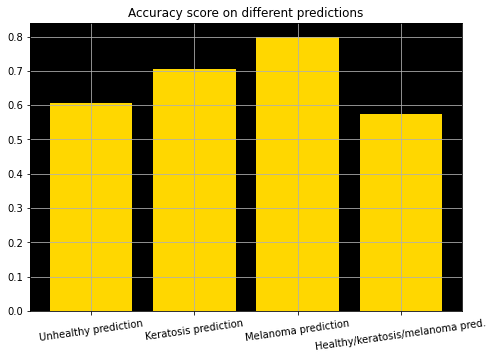

In [11]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
titles = ['Unhealthy prediction','Keratosis prediction','Melanoma prediction', 'Healthy/keratosis/melanoma pred.']
scores = [sum(scores_unhealthy)/5,sum(scores_keratosis)/5,sum(scores_melanoma)/5,sum(scores_all)/5]
ax.bar(titles,scores, color ='gold')
ax.set_facecolor('k')
plt.xticks(rotation=8)
plt.grid()
plt.title('Accuracy score on different predictions')
plt.show()

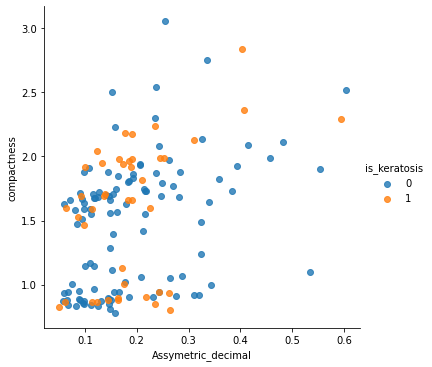

In [12]:
sns.lmplot(x='Assymetric_decimal', y='compactness', data=final_df, hue='is_keratosis', fit_reg=False)
plt.show()

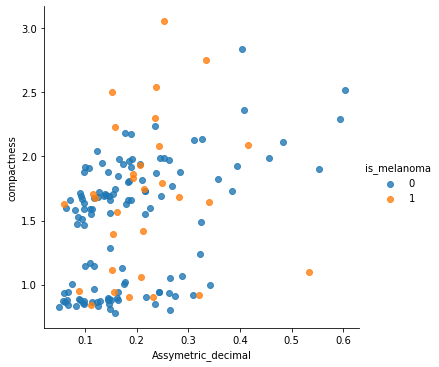

In [13]:
sns.lmplot(x='Assymetric_decimal', y='compactness', data=final_df, hue='is_melanoma', fit_reg=False)
plt.show()

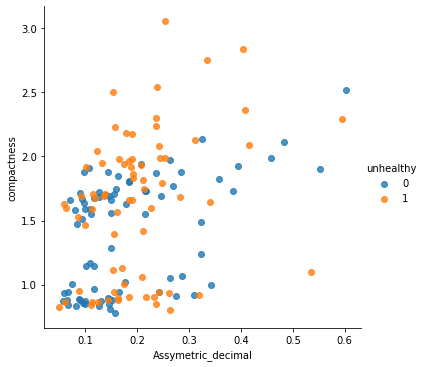

In [14]:
sns.lmplot(x='Assymetric_decimal', y='compactness', data=final_df, hue='unhealthy', fit_reg=False)
plt.show()

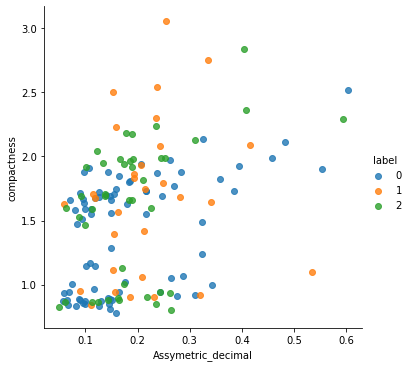

In [15]:
sns.lmplot(x='Assymetric_decimal', y='compactness', data=final_df, hue='label', fit_reg=False)
plt.show()

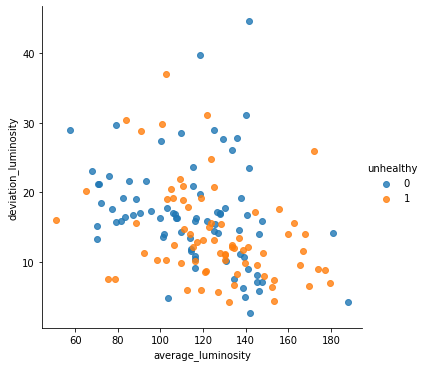

In [16]:
sns.lmplot(x='average_luminosity', y='deviation_luminosity', data=final_df, hue='unhealthy', fit_reg=False)
plt.show()

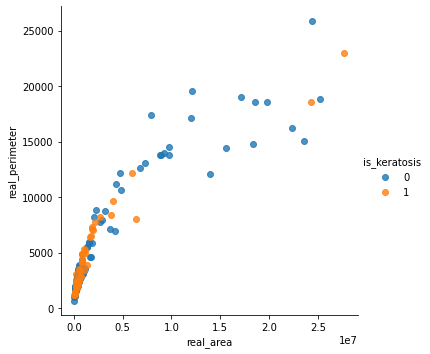

In [17]:
sns.lmplot(x='real_area', y='real_perimeter', data=final_df, hue='is_keratosis', fit_reg=False)
plt.show()

In [18]:
array1 = np.reshape(predicted_unhealthy,(-1,1))
array2 = np.reshape(real_unhealthy_y,(-1,1))
array3 = np.hstack((real_unhealthy_x,array1,array2))
df = pd.DataFrame(array3,columns=['compactness','assymetry','Predicted unhealthy','Real unhealthy'])

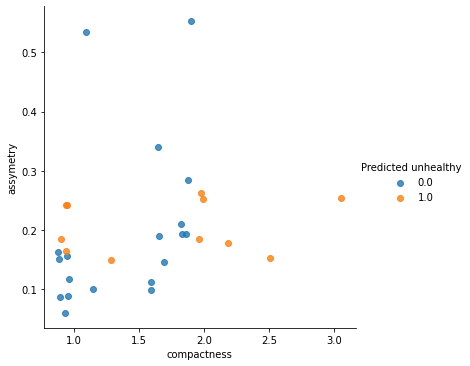

In [19]:
sns.lmplot(x='compactness', y='assymetry', data=df, hue='Predicted unhealthy', fit_reg=False)
plt.show()

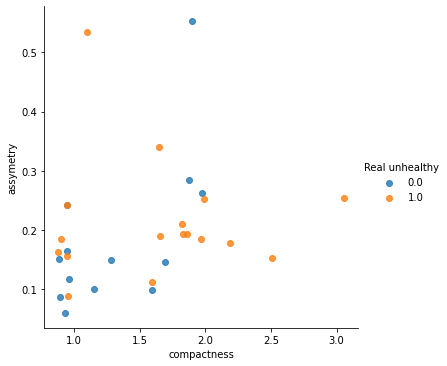

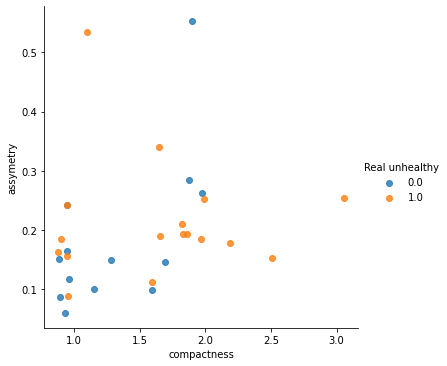

In [20]:
sns.lmplot(x='compactness', y='assymetry', data=df, hue='Real unhealthy', fit_reg=False)
plt.show()

sns.lmplot(x='compactness', y='assymetry', data=df, hue='Real unhealthy', fit_reg=False)
plt.show()

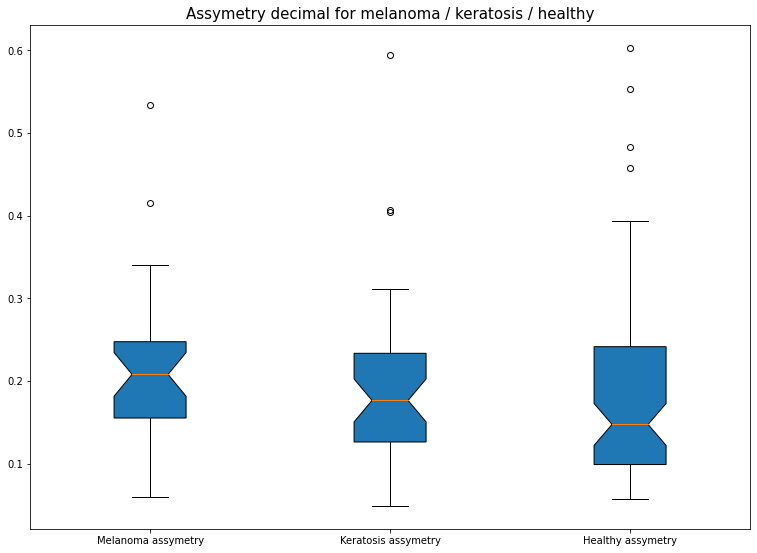

In [21]:
melanoma = final_df[final_df['is_melanoma'] == 1]
keratosis =  final_df[final_df['is_keratosis'] == 1]
unhealthy = final_df[final_df['unhealthy'] == 0]
# plt.boxplot(melanoma['Assymetric_decimal'])

# # Creating dataset

data = [melanoma['Assymetric_decimal'], keratosis['Assymetric_decimal'], unhealthy['Assymetric_decimal']]
  
fig = plt.figure(figsize =(10, 7))
  
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.boxplot(data,patch_artist = True,
                notch ='True', vert = 1)


plt.xticks([1, 2, 3], ['Melanoma assymetry', 'Keratosis assymetry', 'Healthy assymetry'])



plt.title("Assymetry decimal for melanoma / keratosis / healthy", fontsize=15)
# show plot
plt.show()


KeyError: ''

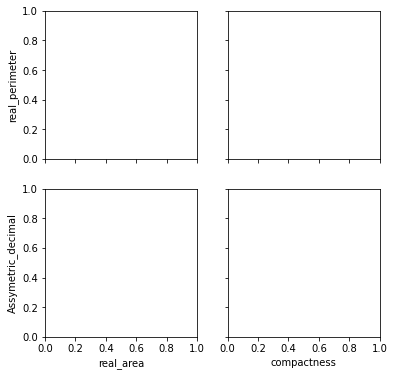

In [22]:
#Apply to data itself
from sklearn import preprocessing

#Fit scaler on our data


sns.pairplot(final_df,x_vars=['real_area','compactness'],y_vars=['real_perimeter','Assymetric_decimal'], hue="", height=3,diag_kind="hist")